<a href="https://colab.research.google.com/github/pacayton/forecast_combination_seminar/blob/main/Forecast_Combination_R.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Forecast Combination Using R**

### Peter Julian Cayton
### *Associate Professor, School of Statistics, University of the Philippines Diliman*

## Materials on GitHub:

https://github.com/pacayton/forecast_combination_seminar

## Contents:
1.   Basic Background
2.   Some Methods in Forecast Combination with Sample Codes
3.   References


Before we begin: 

1. Please load the data from GitHub to your Files folder in Google Colab
2. A preamble of code below

In [ ]:
install.packages("fpp3")
install.packages("fpp2")

library(fpp2)
library(fpp3)

COVID <- read.csv("/content/COVID_national_data.csv")
Monthly <- read.csv("/content/PhilMonthlyData.csv")
Quarterly <- read.csv("/content/PhilQuarterData.csv")

### 1. Basic Background

*   Combining forecasts from different models to improve predictive accuracy has long been known (Bates & Granger 1969; Clemen 1989).
*   Even simply averaging the forecasts from multiple models can improve accuracy greatly (Clemen 1989)
*   Recent use of forecast combinations have surged with the increase in computing power, the growth of data science, and forecasting competitions (Makridakis, Spiliotis, & Assimakopoulos 2020). 
*   More recently, forecast combination methods have been called "ensemble forecasting" but they are essentially similar in terms of combining forecasts from different model configurations.
*   With COVID-19, forecast ensembles have been used for cases, deaths, and hospitalizations in the US (Ray, et al. 2020) and for deaths in multiple countries (Imperial College COVID-19 response team 2022)



### 2. Some Methods in Forecast Combination with Sample Codes

#### 1. Simple Average/Equal Weights Method

> This means averaging the forecasts from different models for the horizon with equal weights






Sample Code in R based on FPP2 (Hyndman & Athanasopoulos 2018) applied to Philippine nonagri data

,Qtr1,Qtr2,Qtr3,Qtr4
1981,117667.0,121185.0,117881.0,125430.0
1982,123269.0,125858.0,123449.0,131250.0
1983,128112.0,136132.0,126157.0,130730.0
1984,121299.0,124943.0,110288.0,117185.0
1985,104479.0,109727.0,103380.0,113743.0
1986,103833.0,112608.0,111294.0,117963.0
1987,107221.0,116357.0,119656.0,123275.0
1988,115605.0,121997.0,124496.0,141191.0
1989,122980.0,131451.0,131832.0,153221.0
1990,131605.0,136898.0,137658.0,153795.0


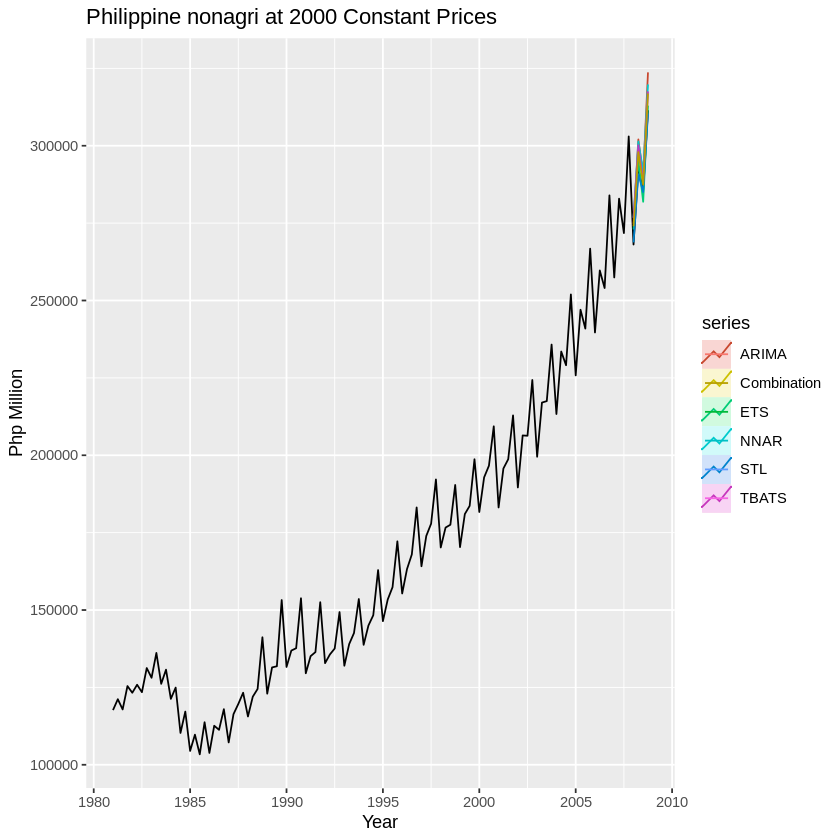

In [14]:
### Extract Philippine nonagri Data from Quarterly file
nonagri <- ts(Quarterly$nonagri, start = c(1981, 1), frequency = 4)

### Show the data
nonagri

### Train Data
nonagri.train <- window(nonagri, end = c(2007, 4))

### Forecast Horizon
h <- length(nonagri) - length(nonagri.train)

### The five models as example
ETS <- forecast(ets(nonagri.train), h=h)
ARIMA <- forecast(auto.arima(nonagri.train, lambda=0, biasadj=TRUE),
  h=h)
STL <- stlf(nonagri.train, lambda=0, h=h, biasadj=TRUE)
NNAR <- forecast(nnetar(nonagri.train), h=h)
TBATS <- forecast(tbats(nonagri.train, biasadj=TRUE), h=h)

### Combining the forecasts
Combination <- (ETS[["mean"]] + ARIMA[["mean"]] +
  STL[["mean"]] + NNAR[["mean"]] + TBATS[["mean"]])/5

### PLot of the Forecasts
autoplot(nonagri) +
  autolayer(ETS, series="ETS", PI=FALSE) +
  autolayer(ARIMA, series="ARIMA", PI=FALSE) +
  autolayer(STL, series="STL", PI=FALSE) +
  autolayer(NNAR, series="NNAR", PI=FALSE) +
  autolayer(TBATS, series="TBATS", PI=FALSE) +
  autolayer(Combination, series="Combination") +
  xlab("Year") + ylab("Php Million") +
  ggtitle("Philippine Non-Agri GVA at 2000 Constant Prices")


In [15]:
### Accuracy Statistics between Methods

c(ETS = accuracy(ETS, nonagri)["Test set","RMSE"],
  ARIMA = accuracy(ARIMA, nonagri)["Test set","RMSE"],
  `STL-ETS` = accuracy(STL, nonagri)["Test set","RMSE"],
  NNAR = accuracy(NNAR, nonagri)["Test set","RMSE"],
  TBATS = accuracy(TBATS, nonagri)["Test set","RMSE"],
  Combination =
    accuracy(Combination, nonagri)["Test set","RMSE"])


ETS       ARIMA     STL-ETS        NNAR       TBATS Combination 
   3403.990    8755.997    1119.054    8065.136    6613.690    4908.065

Sample Code in R based on FPP2 (Hyndman & Athanasopoulos 2018) applied to Philippine COVID data

ARIMA        NNAR       TBATS Combination 
  1997.7470   1861.5841    694.7894   1465.4150

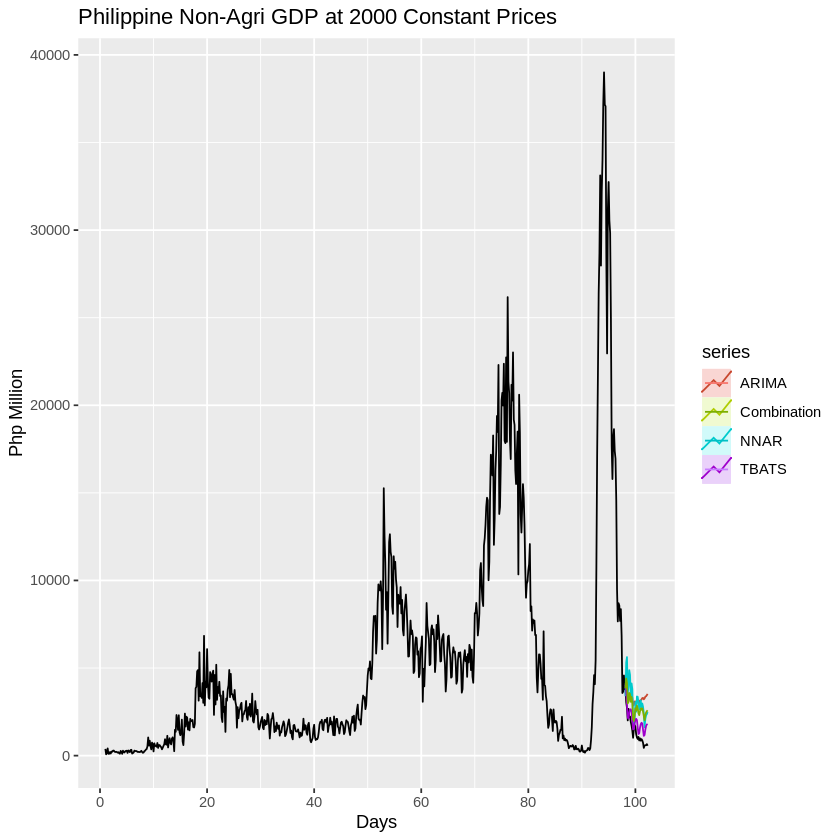

In [26]:
### Extract Philippine COVID Data from file
covid.inc <- ts(COVID$New_Cases, frequency = 7)
## Frequency = 7 is for weekly seasonality

### PS: Remove Omicron Surge Period for the Meantime
## covid.inc <- head(covid, 600)

### Forecast Horizon
h <- 30

### Train Data
covid.train <- head(covid.inc, length(covid.inc)-h )

### The five models as example
ARIMA <- forecast(auto.arima(covid.train, lambda=0, biasadj=TRUE),
  h=h)
NNAR <- forecast(nnetar(covid.train), h=h)
TBATS <- forecast(tbats(covid.train, biasadj=TRUE), h=h)

### Combining the forecasts
Combination <- (ARIMA[["mean"]] + NNAR[["mean"]] + TBATS[["mean"]])/3

### PLot of the Forecasts
autoplot(covid.inc) +
  autolayer(ARIMA, series="ARIMA", PI=FALSE) +
  autolayer(NNAR, series="NNAR", PI=FALSE) +
  autolayer(TBATS, series="TBATS", PI=FALSE) +
  autolayer(Combination, series="Combination") +
  xlab("Days") + ylab("Php Million") +
  ggtitle("Philippine Non-Agri GDP at 2000 Constant Prices")

  ### Accuracy Statistics between Methods

c(ARIMA = accuracy(ARIMA, covid.inc)["Test set","RMSE"],
  NNAR = accuracy(NNAR, covid.inc)["Test set","RMSE"],
  TBATS = accuracy(TBATS, covid.inc)["Test set","RMSE"],
  Combination = accuracy(Combination, covid.inc)["Test set","RMSE"])

### 3. References:

1. Bates, J. M., & Granger, C. W. J. (1969). The combination of forecasts. Operational Research Quarterly, 20(4), 451–468. https://www.tandfonline.com/doi/abs/10.1057/jors.1969.103

2. Clemen, R. (1989). Combining forecasts: A review and annotated bibliography. International Journal of Forecasting, 5(4), 559–583. https://www.sciencedirect.com/science/article/abs/pii/0169207089900125

3. Hyndman, R.J., & Athanasopoulos, G. (2018) Forecasting: principles and practice, 2nd edition, OTexts: Melbourne, Australia. OTexts.com/fpp2. Accessed on 2022-03-01.

4. Hyndman, R.J., & Athanasopoulos, G. (2021) Forecasting: principles and practice, 3rd edition, OTexts: Melbourne, Australia. OTexts.com/fpp3. Accessed on 2022-03-01.

5.  Imperial College COVID-19 response team (2022). Short-term forecasts of COVID-19 deaths in multiple countries. https://mrc-ide.github.io/covid19-short-term-forecasts/. Accessed last 2022-03-09.

6. Makridakis, S., Spiliotis, E., & Assimakopoulos, V. (2020). The M4 Competition: 100,000 time series and 61 forecasting methods. International Journal of Forecasting. Volume 36, Issue 1, January–March 2020, Pages 54-74. https://doi.org/10.1016/j.ijforecast.2019.04.014

7. Ray, et al. (2020). Ensemble Forecasts of Coronavirus Disease 2019 (COVID-19) in the U.S. medRxiv. DOI: https://doi.org/10.1101/2020.08.19.20177493.